In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from torchvision import transforms

from PIL import Image
from torchvision.utils import make_grid
import os

In [3]:
import sys

sys.path.append("/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/")

from adv_manhole.models import load_models, ModelType
from adv_manhole.texture_mapping.depth_utils import process_surface_coordinates, process_depth, disp_to_depth, median_scaling
from adv_manhole.texture_mapping.depth_mapping import DepthTextureMapping
from adv_manhole.evaluate.metrics import error_distance_region, asr_segmentation_region

The console stream is logged into /home/carla_client/sg_logs/console.log


[2024-06-04 07:21:44] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


## Load Dataset

In [4]:
# Load the dataset
carla_dataset = load_dataset("naufalso/carla_hd", cache_dir="/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/notebooks/data/")
print(carla_dataset)

DatasetDict({
    train: Dataset({
        features: ['rgb', 'raw_depth', 'normal', 'semantic', 'camera_config', 'town', 'location_idx', 'camera_idx'],
        num_rows: 1593
    })
    validation: Dataset({
        features: ['rgb', 'raw_depth', 'normal', 'semantic', 'camera_config', 'town', 'location_idx', 'camera_idx'],
        num_rows: 531
    })
    test: Dataset({
        features: ['rgb', 'raw_depth', 'normal', 'semantic', 'camera_config', 'town', 'location_idx', 'camera_idx'],
        num_rows: 532
    })
})


In [5]:
filtered_columns_dataset = carla_dataset.select_columns(
    ["rgb", "raw_depth", "camera_config", "semantic"]
)

data_iterable = {}
batch_size = 8

for data_type, dataset in filtered_columns_dataset.items():
    data_iterable[data_type] = dataset.to_iterable_dataset()
    data_iterable[data_type] = data_iterable[data_type].map(
        lambda example: {
            "local_surface_coors": transforms.ToTensor()(
                process_surface_coordinates(example["raw_depth"], example["camera_config"])
            ),
            "rgb": transforms.ToTensor()(example["rgb"]),
            "road_mask": transforms.ToTensor()(
                np.any(np.array(example['semantic']) == np.array((128, 64, 128)), axis=-1).astype(np.float32)
            ),
            "depth": transforms.ToTensor()(
                process_depth(example["raw_depth"]) * 1000.0 # Convert to meters
            )
        },
        remove_columns=["raw_depth", "camera_config", "semantic"],
    )
    data_iterable[data_type] = DataLoader(
        data_iterable[data_type],
        batch_size=batch_size,
    )

In [6]:
original_index = 0 # Road
# target_indices = list(range(1, 13))  # All classes except Road
target_indices = [3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 17, 18]  # Building, Wall, Fence, Pole, Traffic Light, Traffic Sign, Person, Rider, Car, Truck, Bus, Train, Motorcycle, Bicycle

## Load Adversarial Manholes

In [7]:
imsize = 256  # use small size if no GPU

loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to("cuda", torch.float)

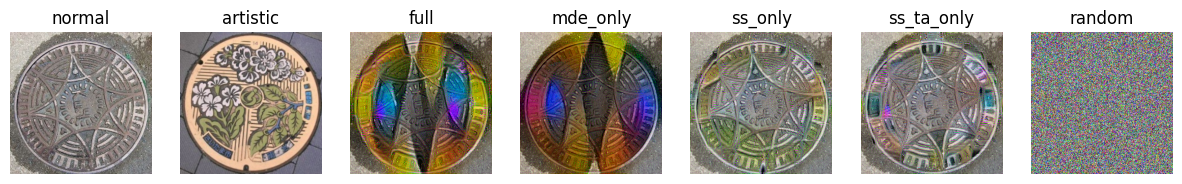

In [8]:
adversarial_manhole_paths = {
    "normal": '/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/notebooks/data/manhole/P1OPDAMV5BDF.jpg',
    "artistic": '/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/notebooks/data/artistic_manhole.jpg',
    "full": '/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/notebooks/generated_textures/full_robust_natural_circle/texture_epoch_24.png',
    "mde_only": '/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/notebooks/generated_textures/full_robust_natural_circle_mde_only/texture_epoch_24.png',
    "ss_only": '/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/notebooks/generated_textures/full_robust_natural_circle_ss_only/texture_epoch_24.png',
    "ss_ta_only": '/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/notebooks/generated_textures/full_robust_natural_circle_targeted_only/texture_epoch_24.png'
}

# Load the manholes
manhole_images = {}
for key, path in adversarial_manhole_paths.items():
    manhole_images[key] = image_loader(path)

manhole_images['random'] = torch.rand_like(manhole_images['normal'])

# Plot the manholes
plt.figure(figsize=(15, 5))
for i, (key, image) in enumerate(manhole_images.items()):
    plt.subplot(1, 7, i+1)
    plt.imshow(image.cpu().squeeze().permute(1, 2, 0))
    plt.title(key)
    plt.axis('off')
plt.show()

## Load Model

In [9]:
# Load MonoDepth2 model
monodepth2_model = load_models(ModelType.MDE, "mono_640x192")

# Load DDRNet model
ddrnet_model = load_models(ModelType.SS, "ddrnet_23")

/home/carla_client/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/carla_client/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
[2024-06-04 07:22:43] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the cityscapes dataset, published under the following terms: https:/

In [10]:
depth_planar_mapping = DepthTextureMapping(
    random_scale=(0.0, 0.01),
    with_circle_mask=True,
    device="cuda",
)

In [11]:
def forward(
        batch, 
        patch_texture = None,
        tex_scales = None,
        xyz_offsets = None,
        device = None,
    ):

    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    
    rgb = batch["rgb"].to(device)
    local_surface_coors = batch["local_surface_coors"].to(device)

    current_batch_size = rgb.shape[0]

    if patch_texture is not None:
        # Repeat the texture to match the batch size
        batched_texture = patch_texture.repeat(
            current_batch_size, 1, 1, 1
        )

        final_images, texture_masks = depth_planar_mapping(
            batched_texture, local_surface_coors, rgb, current_batch_size, tex_scales=tex_scales, xyz_offsets=xyz_offsets, random_scale=False, random_shift=False
        )

        # Predict the depth and semantic segmentation
        predicted_disp = monodepth2_model(final_images)
        predicted_semantic = ddrnet_model(final_images)

        return predicted_disp, predicted_semantic, texture_masks

    else:
        # Predict the depth and semantic segmentation
        predicted_disp = monodepth2_model(rgb)
        predicted_semantic = ddrnet_model(rgb)

        return predicted_disp, predicted_semantic, None

In [12]:
train_total_batch = len(filtered_columns_dataset["train"]) // batch_size + 1 if len(filtered_columns_dataset["train"]) % batch_size != 0 else 0
val_total_batch = len(filtered_columns_dataset["validation"]) // batch_size + 1 if len(filtered_columns_dataset["validation"]) % batch_size != 0 else 0
test_total_batch = len(filtered_columns_dataset["test"]) // batch_size + 1 if len(filtered_columns_dataset["test"]) % batch_size != 0 else 0

In [13]:
eval_metrics = {
    'train': defaultdict(list),
    'validation': defaultdict(list),
    'test': defaultdict(list)
}

for datatype, total in zip(['train', 'validation', 'test'], [train_total_batch, val_total_batch, test_total_batch]):
    with tqdm(
        data_iterable[datatype], total=total, desc=f"{datatype} Evaluation"
    ) as pbar:
        for batch in pbar:
            metrics = {}

            road_masks = batch["road_mask"].cuda()
            gt_depth = batch["depth"].to('cuda')

            with torch.no_grad():
                current_batch_size = batch["rgb"].shape[0]
                tex_scales = depth_planar_mapping._get_texture_scale(current_batch_size)
                xyz_offsets = depth_planar_mapping._get_texture_offset(current_batch_size)

                ori_predicted_disp, ori_predicted_semantic, _ = forward(batch, tex_scales=tex_scales, xyz_offsets=xyz_offsets)
                ori_predicted_depth = disp_to_depth(ori_predicted_disp)
                ori_scaled_predicted_depth, ratio = median_scaling(ori_predicted_depth, gt_depth)

                for manhole_name, manhole_image in manhole_images.items():
                    # print(key)
                    predicted_disp, predicted_semantic, texture_masks = forward(batch, manhole_image, tex_scales=tex_scales, xyz_offsets=xyz_offsets)

                    scaled_predicted_depth = disp_to_depth(predicted_disp) * ratio

                    # Calculate the error distance
                    mde_metrics = error_distance_region(scaled_predicted_depth, ori_scaled_predicted_depth, texture_masks, road_masks, distance_threshold=0.25)

                    for mde_key in mde_metrics.keys():
                        eval_metrics[datatype][f"{manhole_name}/{mde_key}"].append(mde_metrics[mde_key].item())

                    # Calculate the ASR
                    ss_metrics = asr_segmentation_region(predicted_semantic, ori_predicted_semantic, original_index, target_indices, texture_masks, road_masks)
                    for ss_key in ss_metrics.keys():
                        eval_metrics[datatype][f"{manhole_name}/{ss_key}"].append(ss_metrics[ss_key].item())

                metrics.update({
                    key: np.mean(eval_metrics[datatype][key])
                    for key in eval_metrics[datatype].keys()
                })

            pbar.set_postfix(metrics)

test Evaluation:  33%|███▎      | 66/200 [04:17<08:40,  3.88s/it, normal/ed_mean=0.0288, normal/ed_ratio=0.025, normal/asr_ua_mean=0, normal/asr_ta_mean=0, normal/ua_ratio=0.00178, normal/ta_ratio=1.53e-5, artistic/ed_mean=0.0386, artistic/ed_ratio=0.0377, artistic/asr_ua_mean=2.88e-5, artistic/asr_ta_mean=0, artistic/ua_ratio=0.00353, artistic/ta_ratio=4.03e-5, full/ed_mean=0.432, full/ed_ratio=2.32, full/asr_ua_mean=0.963, full/asr_ta_mean=0.963, full/ua_ratio=1.02, full/ta_ratio=0.986, mde_only/ed_mean=0.435, mde_only/ed_ratio=2.38, mde_only/asr_ua_mean=0.000108, mde_only/asr_ta_mean=0, mde_only/ua_ratio=0.00498, mde_only/ta_ratio=6.13e-5, ss_only/ed_mean=0.0467, ss_only/ed_ratio=0.0435, ss_only/asr_ua_mean=0.959, ss_only/asr_ta_mean=0.951, ss_only/ua_ratio=1.08, ss_only/ta_ratio=0.969, ss_ta_only/ed_mean=0.0517, ss_ta_only/ed_ratio=0.0374, ss_ta_only/asr_ua_mean=0.968, ss_ta_only/asr_ta_mean=0.968, ss_ta_only/ua_ratio=1.03, ss_ta_only/ta_ratio=0.984, random/ed_mean=0.0291, random/e

test Evaluation:  34%|███▎      | 67/200 [04:19<08:35,  3.87s/it, normal/ed_mean=0.0287, normal/ed_ratio=0.0246, normal/asr_ua_mean=0, normal/asr_ta_mean=0, normal/ua_ratio=0.00176, normal/ta_ratio=1.51e-5, artistic/ed_mean=0.0385, artistic/ed_ratio=0.0372, artistic/asr_ua_mean=2.84e-5, artistic/asr_ta_mean=0, artistic/ua_ratio=0.00349, artistic/ta_ratio=3.97e-5, full/ed_mean=0.432, full/ed_ratio=2.33, full/asr_ua_mean=0.964, full/asr_ta_mean=0.964, full/ua_ratio=1.02, full/ta_ratio=0.987, mde_only/ed_mean=0.435, mde_only/ed_ratio=2.39, mde_only/asr_ua_mean=0.000106, mde_only/asr_ta_mean=0, mde_only/ua_ratio=0.00492, mde_only/ta_ratio=6.04e-5, ss_only/ed_mean=0.0473, ss_only/ed_ratio=0.0457, ss_only/asr_ua_mean=0.96, ss_only/asr_ta_mean=0.951, ss_only/ua_ratio=1.08, ss_only/ta_ratio=0.97, ss_ta_only/ed_mean=0.0524, ss_ta_only/ed_ratio=0.0405, ss_ta_only/asr_ua_mean=0.969, ss_ta_only/asr_ta_mean=0.968, ss_ta_only/ua_ratio=1.03, ss_ta_only/ta_ratio=0.985, random/ed_mean=0.0291, random/ed

In [14]:
import pandas as pd

train_eval_df = pd.DataFrame(eval_metrics['train'])
validation_eval_df = pd.DataFrame(eval_metrics['validation'])
test_eval_df = pd.DataFrame(eval_metrics['test'])

In [16]:
train_eval_df.mean()

normal/ed_mean            0.026849
normal/ed_ratio           0.022634
normal/asr_ua_mean        0.000000
normal/asr_ta_mean        0.000000
normal/ua_ratio           0.002606
normal/ta_ratio           0.000011
artistic/ed_mean          0.035509
artistic/ed_ratio         0.027081
artistic/asr_ua_mean      0.000033
artistic/asr_ta_mean      0.000003
artistic/ua_ratio         0.004570
artistic/ta_ratio         0.000030
full/ed_mean              0.436096
full/ed_ratio             2.300531
full/asr_ua_mean          0.966472
full/asr_ta_mean          0.966190
full/ua_ratio             1.027820
full/ta_ratio             0.988773
mde_only/ed_mean          0.439716
mde_only/ed_ratio         2.368270
mde_only/asr_ua_mean      0.000317
mde_only/asr_ta_mean      0.000000
mde_only/ua_ratio         0.005867
mde_only/ta_ratio         0.000031
ss_only/ed_mean           0.043678
ss_only/ed_ratio          0.031984
ss_only/asr_ua_mean       0.962651
ss_only/asr_ta_mean       0.955459
ss_only/ua_ratio    

In [17]:
validation_eval_df.mean()

normal/ed_mean            0.026564
normal/ed_ratio           0.025574
normal/asr_ua_mean        0.000092
normal/asr_ta_mean        0.000000
normal/ua_ratio           0.004818
normal/ta_ratio           0.000011
artistic/ed_mean          0.036473
artistic/ed_ratio         0.031262
artistic/asr_ua_mean      0.000238
artistic/asr_ta_mean      0.000000
artistic/ua_ratio         0.006492
artistic/ta_ratio         0.000026
full/ed_mean              0.420883
full/ed_ratio             2.203598
full/asr_ua_mean          0.962505
full/asr_ta_mean          0.962377
full/ua_ratio             1.037247
full/ta_ratio             0.991020
mde_only/ed_mean          0.425017
mde_only/ed_ratio         2.271310
mde_only/asr_ua_mean      0.001053
mde_only/asr_ta_mean      0.000000
mde_only/ua_ratio         0.008889
mde_only/ta_ratio         0.000024
ss_only/ed_mean           0.043923
ss_only/ed_ratio          0.034162
ss_only/asr_ua_mean       0.961584
ss_only/asr_ta_mean       0.954816
ss_only/ua_ratio    

In [18]:
test_eval_df.mean()

normal/ed_mean            0.028731
normal/ed_ratio           0.024586
normal/asr_ua_mean        0.000000
normal/asr_ta_mean        0.000000
normal/ua_ratio           0.001758
normal/ta_ratio           0.000015
artistic/ed_mean          0.038540
artistic/ed_ratio         0.037156
artistic/asr_ua_mean      0.000028
artistic/asr_ta_mean      0.000000
artistic/ua_ratio         0.003491
artistic/ta_ratio         0.000040
full/ed_mean              0.432231
full/ed_ratio             2.330479
full/asr_ua_mean          0.963569
full/asr_ta_mean          0.963545
full/ua_ratio             1.023185
full/ta_ratio             0.986534
mde_only/ed_mean          0.435056
mde_only/ed_ratio         2.393510
mde_only/asr_ua_mean      0.000106
mde_only/asr_ta_mean      0.000000
mde_only/ua_ratio         0.004925
mde_only/ta_ratio         0.000060
ss_only/ed_mean           0.047336
ss_only/ed_ratio          0.045737
ss_only/asr_ua_mean       0.959721
ss_only/asr_ta_mean       0.951073
ss_only/ua_ratio    

In [ ]:
# SAVE TO CSV
train_eval_df.to_csv("/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/notebooks/output/train_eval_metrics_random_pos.csv")
validation_eval_df.to_csv("/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/notebooks/output/val_eval_metrics_random_pos.csv")
test_eval_df.to_csv("/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/notebooks/output/test_eval_metrics_random_pos.csv")